In [13]:
import torch
print(torch.cuda.is_available())

True


In [14]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
# Set the object to None
large_object = None

# Call the garbage collector
import gc
gc.collect()

# Clear PyTorch cache
import torch
torch.cuda.empty_cache()

In [16]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


In [17]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# import sys
# from PIL import Image
# sys.modules['Image'] = Image 

In [18]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

import matplotlib.pyplot as plt

# Define directories
train_dir = r"\Users\ANUSHKA\Downloads\archive\Common_Indian_Plants/TRAIN"
val_dir = r"\Users\ANUSHKA\Downloads\archive\Common_Indian_Plants/VALID"
test_dir = r"\Users\ANUSHKA\Downloads\archive\Common_Indian_Plants/TEST"
# Define data generators for training and validation with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Define batch size
batch_size = 8

# Create generators to load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse'  # Adjust class_mode based on your classification task
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse'  # Adjust class_mode based on your classification task
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False  # Adjust class_mode based on your classification task
)

# Load pre-trained ResNet50 model
resnet = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze pre-trained layers
for layer in resnet.layers:
    layer.trainable = False

# Fine-tuning
for layer in resnet.layers[-10:]:
    layer.trainable = True

# Add custom dense layers for classification
x = GlobalAveragePooling2D()(resnet.output)
x = Dropout(0.5)(x)  # Adding dropout for regularization
prediction = Dense(10, activation='softmax')(x)  # Adjust the number of output classes

# Create the model
model = Model(inputs=resnet.input, outputs=prediction)

# Compile the model
optimizer = Adam(lr=0.001)  # Initial learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)



Found 8418 images belonging to 10 classes.
Found 2173 images belonging to 10 classes.
Found 3634 images belonging to 10 classes.


c:\Users\ANUSHKA\anaconda3\envs\final\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [20]:
from PIL import Image

Epoch 1/30
1053/1053 [==============================] - 156s 139ms/step - loss: 0.3759 - accuracy: 0.8837 - val_loss: 0.1741 - val_accuracy: 0.9471 - lr: 0.0010
Epoch 2/30
1053/1053 [==============================] - 106s 101ms/step - loss: 0.1473 - accuracy: 0.9527 - val_loss: 0.1086 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 3/30
1053/1053 [==============================] - 105s 100ms/step - loss: 0.1166 - accuracy: 0.9639 - val_loss: 0.1859 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 4/30
1053/1053 [==============================] - 100s 95ms/step - loss: 0.0869 - accuracy: 0.9717 - val_loss: 0.0333 - val_accuracy: 0.9894 - lr: 0.0010
Epoch 5/30
1053/1053 [==============================] - 102s 96ms/step - loss: 0.0871 - accuracy: 0.9716 - val_loss: 0.0505 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 6/30
1053/1053 [==============================] - 105s 99ms/step - loss: 0.0736 - accuracy: 0.9754 - val_loss: 0.0960 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 7/30
1053/1053 [===============

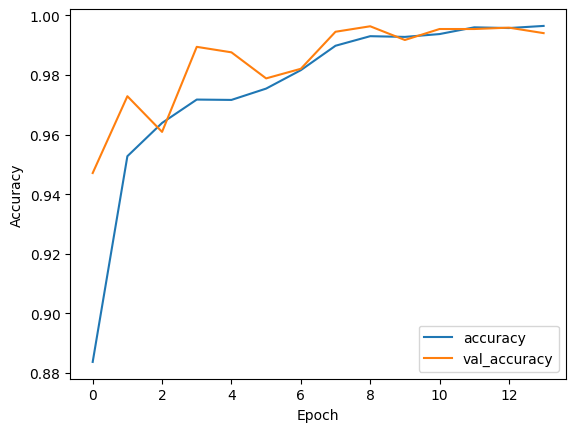

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,  # Adjust the number of epochs
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stop, reduce_lr]
)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()



C:\Users\ANUSHKA\AppData\Local\Temp\ipykernel_12008\1248099273.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)


454/454 [==============================] - 32s 69ms/step - loss: 0.0312 - accuracy: 0.9917
Test Loss: 0.031244786456227303
Test Accuracy: 0.9917446374893188


C:\Users\ANUSHKA\AppData\Local\Temp\ipykernel_12008\1248099273.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=test_steps, verbose=1)


454/454 [==============================] - 29s 58ms/step
Confusion Matrix:
[[408   0   0   0   1   0   0   1   0   0]
 [  0 291   0   0   0   0   0   0   0   0]
 [  0   0 393   0   2  11   0   0   0   0]
 [  0   0   0 396   0   0   0   0   0   0]
 [  0   0   0   0 315   0   0   0   0   0]
 [  0   0   1   0   0 382   2   0   0   0]
 [  0   0   0   0   0   0 376   0   0   1]
 [  0   0   0   0   0   0   0 262   0   0]
 [  0   0   0   0   2   0   0   0 428   0]
 [  0   0   0   0   9   0   0   0   0 353]]


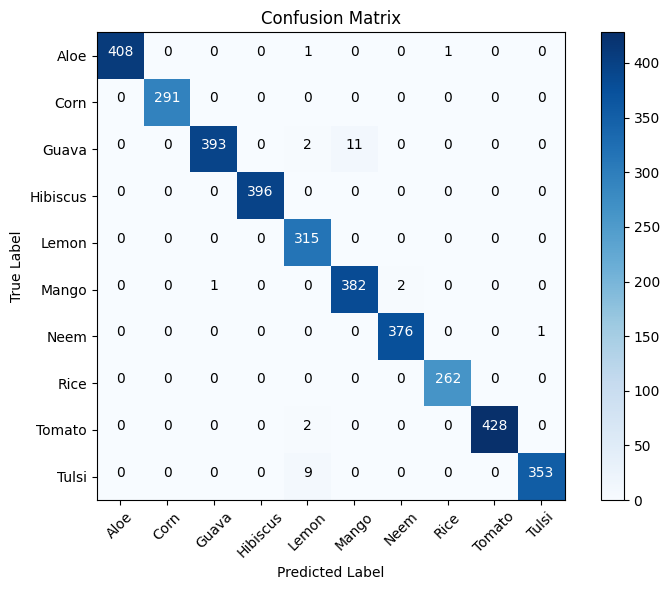

Classification Report:
              precision    recall  f1-score   support

        Aloe       1.00      1.00      1.00       410
        Corn       1.00      1.00      1.00       291
       Guava       1.00      0.97      0.98       406
    Hibiscus       1.00      1.00      1.00       396
       Lemon       0.96      1.00      0.98       315
       Mango       0.97      0.99      0.98       385
        Neem       0.99      1.00      1.00       377
        Rice       1.00      1.00      1.00       262
      Tomato       1.00      1.00      1.00       430
       Tulsi       1.00      0.98      0.99       362

    accuracy                           0.99      3634
   macro avg       0.99      0.99      0.99      3634
weighted avg       0.99      0.99      0.99      3634



In [23]:
# Testing the model
test_steps = test_generator.n / batch_size
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Generating predictions for the test set
test_generator.reset()  # Reset generator before calling predict_generator
predictions = model.predict_generator(test_generator, steps=test_steps, verbose=1)
predicted_classes = predictions.argmax(axis=-1)

# Creating the confusion matrix
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adding text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [24]:
#tf.keras.models.load_model('\Users\ANUSHKA\Downloads\Resnetnew.h5')
model.save("Resnetnew.h5")